# Forecasting LSTM Model for Cellular Differentation
### This project splits the biological data by timepoints to predict future temporal data

Note: In order to run the program, you must have all the following libraries imported into your database and replicate the setup. This process is detailed in the README.

The research paper goes into further depth about the code here and compares the two tasks- please refer for further reading.

The code is mostly written as functions in the shared_utils file for modularity, but explained in depth here.

## Imports

In [ ]:
from shared_utils import *

This command imports all neccacary functions from shared_utils.py in order for the program to run. The program is written this way to keep it modular and not too overwhelming in this notebook where the code is run.

## Loading Data

### Load Data from [GSE75748](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748)

The biological data are the temporal 758 single cells that differentiate from the mesoderm phase to the definitive endoderm.

In [2]:
print("Starting Cell-Based Forecasting...")

adata = load_data()

Starting Cell-Based Forecasting...
Loading data from GSE75748_sc_time_course_ec.csv...


The load_data() function uses pandas to read the large csv data file under the local variable df. Then once we have the csv file in df, the function converts it into a scanpy variable "adata" for biological preprocessing and visualization, and returns it into the public variable name "adata" which we can now use. 

In [3]:
adata = add_timepoint_data_to_adata(adata) 

Extracting timepoints from cell names to add to adata
Timepoint data added to adata.


Next, we want to add timepoints to the scanpy variable adata so that we can section the data by timepoint, a process that is very important for temporal data like cell differentiation. The temporal data can actually be extracted from the cell names since they start with H9.__h and the timepoint is there instead of the blank. So all we do to add the timepoint data into it's own column in adata is extract the timepoint from the names of the cells and add it into the column for each cell.

In [4]:
add_qc_metrics(adata)

QC metrics added to adata.obs:
['n_genes_by_counts', 'total_counts']


AnnData object with n_obs × n_vars = 758 × 19189
    obs: 'timepoint', 'sample_number', 'n_genes_by_counts', 'total_counts'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

The function makes gene names unique and flags mitochondrial genes in adata.var. It then computes per-cell QC metrics (total_counts, n_genes_by_counts, pct_counts_mt) and returns the annotated AnnData without filtering or removing anything.

Plotting before filtering...


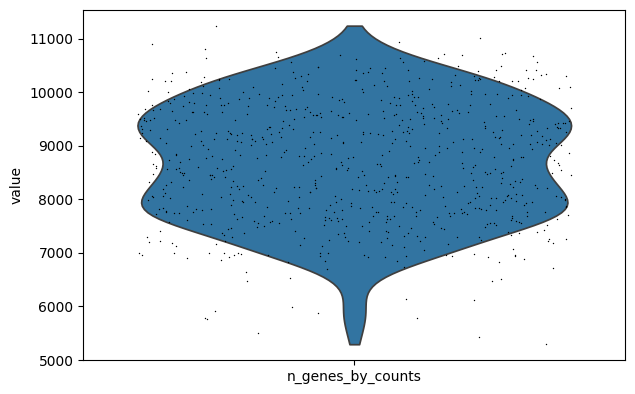

In [5]:
plot_before_filtering(adata) 

We can see from the graph that our expression data is extremely varied before filitering. This graph highlights why it is important to do preprocessing, especially in the biological sense, because in order for the models to perform well, they must read off patterns. And patterns are easily recognized with more concise data rather than the random mess we have with real expression data.

## Data Preprocessing

In [6]:
adata_hvg = preprocess_data(adata)

Starting data preprocessing
Filtering cells and genes

Data shape after filtering: (758, 16863)

Normalizing and log transforming data


HVG filtering:
Highly variable genes found: 2000
After HVG filtering:

[0, 12, 24, 36, 72, 96]


Single-cell RNA sequencing data needs cleaning and processing before it can be used. Cells expressing fewer than 500 genes were removed, and genes expressed in fewer than 3 cells were also removed becausethey did not provide enough useful information. Normalization was applied so that very highly expressed genes did not dominate the results. A standard log-transformation was used. In the end, adata_hvg contains the 2000 most variable genes (from 19189) across all 758 cells. We select the most variable genes because they give us the most expression data to work.

In [7]:
gene_time_matrix, _ = create_gene_time_matrix(adata_hvg)

Creating gene-time matrix
  Expression data shape: (92, 2000)
  First three values in row: [1.06525890e-03 1.83659651e+00 6.07498533e-01]...

  Expression data shape: (102, 2000)
  First three values in row: [0.00105627 0.36513232 0.55956094]...

  Expression data shape: (66, 2000)
  First three values in row: [0.0053351  0.25281378 0.10561054]...

  Expression data shape: (172, 2000)
  First three values in row: [0.0036584  0.75394466 0.18623813]...

  Expression data shape: (138, 2000)
  First three values in row: [4.36164506e-04 1.05440790e+00 1.25326741e+00]...

  Expression data shape: (188, 2000)
  First three values in row: [0.01164793 0.91026402 1.5075981 ]...

Gene-time matrix fully created with shape: (2000, 6)


This function builds a gene-time matrix by averaging gene expression values across all cells belonging to each timepoint. For every timepoint, it selects the cells measured at that time, extracts their expression matrix, and computes the mean expression for each gene. The output show how many cells were present at each timepoint (for example, 92, 102, 66, etc.) and a few sample averaged values for the first three genes. These averaged values become a single column in the final matrix. After processing all timepoints, the resulting matrix has one row per gene and one column per timepoint. In the output, the matrix shape is (2000, 6), meaning 2,000 genes and 6 timepoints. This format provides a clean summary of expression trends over time, where each row represents how a gene’s average expression changes across the measured timepoints. Additionlly this matrix will make splitting the code especially easy.

## Splitting Data and Creating Windows

In [8]:
train_data, val_data, test_data = split_by_cells(gene_time_matrix)

Temporal holdout splitting: 6 timepoints total
Train: timepoints 0-3 (4 points)
Val: timepoints 2-4 (3 points)
Test: timepoints 3-5 (3 points)


In [9]:
X_train, y_train = create_cell_windows(train_data, window_size=2)
X_val, y_val = create_cell_windows(val_data, window_size=2)
X_test, y_test = create_cell_windows(test_data, window_size=2)

Cell windows created: 2 samples. X shape: (2, 2, 2000), y shape: (2, 2000)
Cell windows created: 1 samples. X shape: (1, 2, 2000), y shape: (1, 2000)
Cell windows created: 1 samples. X shape: (1, 2, 2000), y shape: (1, 2000)


The create_cell_windows function is turning the time series data for each cell into short example windows that the models can learn from. The code first transposes the data so that timepoints run down the rows and genes run across the columns. This makes it easy to slice consecutive time steps. For each place where there are enough timepoints, the function grabs a fixed number of past steps (the window_size) and uses them as the input X, and it grabs the next one or more timepoints (the prediction_steps) as the target y. So each X sample is a small block of time (for example two past measurements for every gene) and each y sample is the future measurement that the model should predict. When the notebook prints something like X shape: (2, 2, 2000) that means there are 2 training examples, each example contains 2 time steps, and at each time step there are 2000 gene features; similarly y shape: (2, 2000) means each example predicts a vector of 2000 gene values. These windows let a sequence model like an LSTM learn how gene expression changes over time and let a feedforward model learn from the flattened version of those same windows.

In [10]:
input_shape = (X_train.shape[1], X_train.shape[2]) 
output_size = y_train.shape[1] if y_train.ndim > 1 else 1 

This cell defines the shapes that the neural networks will accept and predict, and understanding those two variables prevents many common errors. input_shape tells the model how many time steps and how many features appear in each example: it is the pair (window_size, n_features). For instance (2, 2000) means each input example contains two consecutive timepoints and at each timepoint there are 2000 gene expression measurements. output_size tells the model how many numbers it must predict for each input: if y is a vector of gene expression values then output_size will be the number of genes, but if y is a single number per sample then output_size will be 1. Choosing these shapes correctly is essential because layers like Dense or the final LSTM output layer need to know how many outputs to produce; if the shapes don’t match the data, training will fail with a shape mismatch error.

## Building the LSTM and Feedforward Models

In [11]:
lstm_model = build_lstm_model(input_shape, output_size)

Building LSTM model: Input shape=(2, 2000), Output size=2000


/Users/paavan/dev/Cell_Diff/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM stands for Long Short-Term Memory and it is a type of recurrent neural network designed to remember patterns across time. Unlike a feedforward network, an LSTM processes the input one time step at a time and keeps an internal state that can carry information forward, which helps it learn sequences such as gene expression trends. The code stacks two LSTM layers: the first returns a sequence so the second LSTM can process the whole transformed sequence, and the final Dense layers convert the learned temporal features into the output vector of predicted gene values. dropout randomly disables some connections during training to reduce overfitting, and recurrent_dropout does the same inside the recurrent connections; both help the model generalize better when the dataset is small. The model uses the Adam optimizer, which adapts the learning rate for each weight automatically and often speeds up training compared to vanilla SGD. I set larger layer sizes for the cell level prediction task because predicting a whole cell state uses more information than predicting a single gene. If you see warnings about passing input_shape directly to layers it won’t break the code, but one can use an explicit Input() layer for clarity. Overall, an LSTM is useful here because it can learn how past gene levels influence future levels in a time aware way, and is usually considered one of the best nueral networks for prediction tasks.

In [12]:
ff_model = build_feedforward_model(input_shape, output_size)

Building feedforward model: Input shape=(2, 2000), Output size=2000


/Users/paavan/dev/Cell_Diff/.venv/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The feedforward model takes each time window and flattens it into one long list of numbers, losing the order of the time steps but keeping all the values; flattening means the two time steps and many genes become one long vector that a normal neural network can process. After flattening, the model uses one or more Dense (fully connected) layers, which calculate weighted sums and pass them through a simple activation function to produce a learned transformation, and then a final Dense layer outputs the predictions. Dropout is used between layers to reduce overfitting by randomly ignoring some neurons during training, which forces the model to build more predictive and robust features. The model is compiled with stochastic gradient descent (SGD) as the optimizer. SGD slowly nudges the model weights to reduce the error, and uses mean squared error (MSE) as the loss function; MSE penalizes large errors more strongly and is common for regression tasks, while mean absolute error (MAE) is kept as a metric because it is easy to interpret as the average prediction error. In short, the feedforward model is straightforward and usually faster to train (you can test this by running the code yourself), but it does not explicitly learn temporal order, so it is best at learning relationships that don’t depend on the order of past timepoints. Additionally, as you will see in the results section, the feedforward model finds it extremely difficult to learn such complex temporal data and it's performance will be significantly worse than the LSTM model. Although this result is expected, the feedforward is used as a control, and helps us understand the results of the LSTM model more completely.

## Training the LSTM and Feedforward Models

In [13]:
print("\nTraining LSTM Model")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=250,
    verbose=1,
    callbacks=get_training_callbacks()
)
print(f"LSTM training completed after {len(lstm_history.history['loss'])} epochs.")


Training LSTM Model
Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.1916 - mae: 0.2214 - val_loss: 0.2890 - val_mae: 0.2636 - learning_rate: 0.0010
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.1850 - mae: 0.2168 - val_loss: 0.2698 - val_mae: 0.2479 - learning_rate: 0.0010
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - loss: 0.1681 - mae: 0.2017 - val_loss: 0.2317 - val_mae: 0.2191 - learning_rate: 0.0010
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 0.1377 - mae: 0.1780 - val_loss: 0.1820 - val_mae: 0.1994 - learning_rate: 0.0010
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 0.1057 - mae: 0.1715 - val_loss: 0.1487 - val_mae: 0.2151 - learning_rate: 0.0010
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - loss: 0.0912 - mae: 0.1961 - val_loss: 0.1285 - val_mae: 0.2047 - learning_rate: 0.0010
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - loss: 0.0785 - mae: 0.1885 - val_loss: 0.1158 - val_mae: 0.1801 - learning_rate: 0.

LSTMs typically take more time per epoch because they perform calculations across time steps, and they can also overfit more easily when the dataset is small because they have more parameters and more capacity to memorize the training data. The same training helpers (EarlyStopping and ReduceLROnPlateau) are especially important for recurrent models: EarlyStopping prevents the LSTM from training until it memorizes the training set, and the learning rate reducer helps fine tune the weights once the loss plateaus. When reviewing the training log, you should check the same things as for the feedforward model, whether training and validation losses are decreasing and whether they diverge, but you should also be patient with training time and consider smaller LSTM sizes or stronger dropout if the validation score is much worse than the training score.

In [14]:
print("\nTraining Feedforward Model")
ff_history = ff_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=250,
    verbose=1,
    callbacks=get_training_callbacks()
)
print(f"Feedforward training completed after {len(ff_history.history['loss'])} epochs.")


Training Feedforward Model
Epoch 1/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 896ms/step - loss: 0.3356 - mae: 0.4086 - val_loss: 0.3698 - val_mae: 0.3807 - learning_rate: 0.0100
Epoch 2/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 0.3101 - mae: 0.3887 - val_loss: 0.3671 - val_mae: 0.3782 - learning_rate: 0.0100
Epoch 3/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.3136 - mae: 0.3908 - val_loss: 0.3645 - val_mae: 0.3758 - learning_rate: 0.0100
Epoch 4/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - loss: 0.2952 - mae: 0.3770 - val_loss: 0.3623 - val_mae: 0.3736 - learning_rate: 0.0100
Epoch 5/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 0.3086 - mae: 0.3824 - val_loss: 0.3600 - val_mae: 0.3713 - learning_rate: 0.0100
Epoch 6/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 0.2934 - mae: 0.3685 - val_loss: 0.3577 - val_mae: 0.3692 - learning_rate: 0.0100
Epoch 7/250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.3026 - mae: 0.3820 - val_loss: 0.3553 - val_mae: 0.3668 - learnin

During training the model repeatedly looks at the training data in passes called epochs; after each epoch the notebook prints metrics such as the training loss (how far the model’s predictions are from the targets on the training set) and validation loss (the same measurement but on a held-out set not used for updating the model). The validation numbers give a better idea of how the model will perform on new, unseen data. EarlyStopping will stop training automatically if the validation loss does not improve for a certain number of epochs, preventing the model from overfitting to the training set, and ReduceLROnPlateau reduces the learning rate if validation loss stops improving so the optimizer can take smaller, more careful steps later in training. restore_best_weights=True ensures that after training finishes we keep the model weights from the epoch that had the best validation loss. When you look at the printed training curves, a healthy run shows both training and validation loss decreasing; if the validation loss starts rising while the training loss keeps decreasing, that is a sign of overfitting and the EarlyStopping callback will typically stop training before it gets worse.

## Evaluating the Models Performance

In [15]:
print("\n--- Final LSTM Model Evaluation ---")
y_pred_lstm = lstm_model.predict(X_test)
lstm_rmse, lstm_mae, lstm_r2, y_pred_lstm = evaluate_performance(y_test, y_pred_lstm)


--- Final LSTM Model Evaluation ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 672ms/step
RMSE: 0.2780
MAE:  0.1394
R²:   0.5728


In [16]:
print("\n--- Final Feedforward Model Evaluation ---")
y_pred_ff = ff_model.predict(X_test)
ff_rmse, ff_mae, ff_r2, y_pred_ff = evaluate_performance(y_test, y_pred_ff)


--- Final Feedforward Model Evaluation ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
RMSE: 0.5167
MAE:  0.3118
R²:   -0.4756


After making predictions we compute three common metrics: RMSE (root mean squared error) gives an error measure in the same units as the data and penalizes large errors more than small ones, MAE (mean absolute error) is the average absolute difference between prediction and actual value and is easy to interpret, and R² measures how much of the variation in the data the model explains (a value near 1 is good, around 0 means the model is no better than predicting the average, less than 0 means worse than predicting random). The visualization helpers complement these numbers: a prediction vs actual plot shows where the model systematically under or overpredicts and highlights outliers; plotting the average expression for cell level predictions reduces dimensionality so you can see broad trends. Error histograms show whether errors are centered near zero and whether there are many large mistakes, and a scatter plot of predicted vs actual with the diagonal line helps you see how closely points cluster around perfect predictions. Finally, the performance comparison bar chart places LSTM and feedforward metrics side by side so you can quickly see which model is better by each measure. Use the numerical metrics to quantify performance and the plots to diagnose where the model is making the biggest mistakes and whether those mistakes are random or systematic.

## Plotting Results LSTM vs Feedforward

Note: For plotting, please refer to the research paper for further information.


Plotting Training Histories


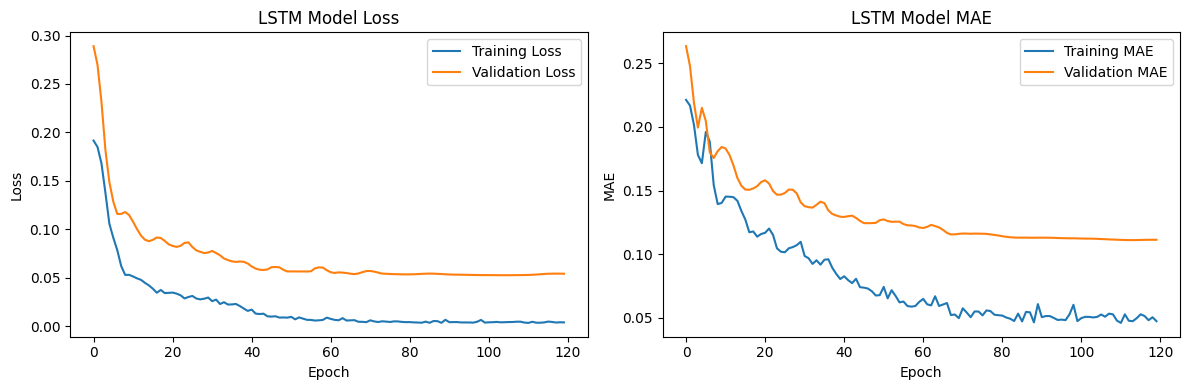

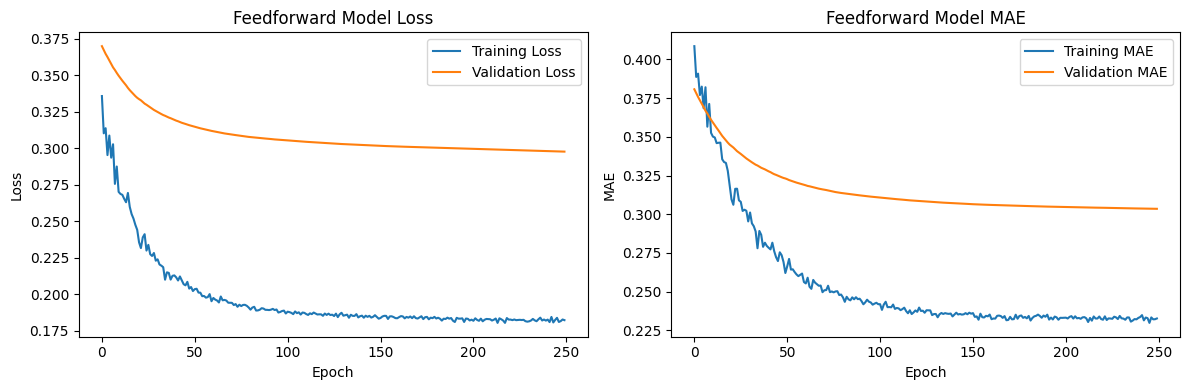


Plotting Prediction Comparisons


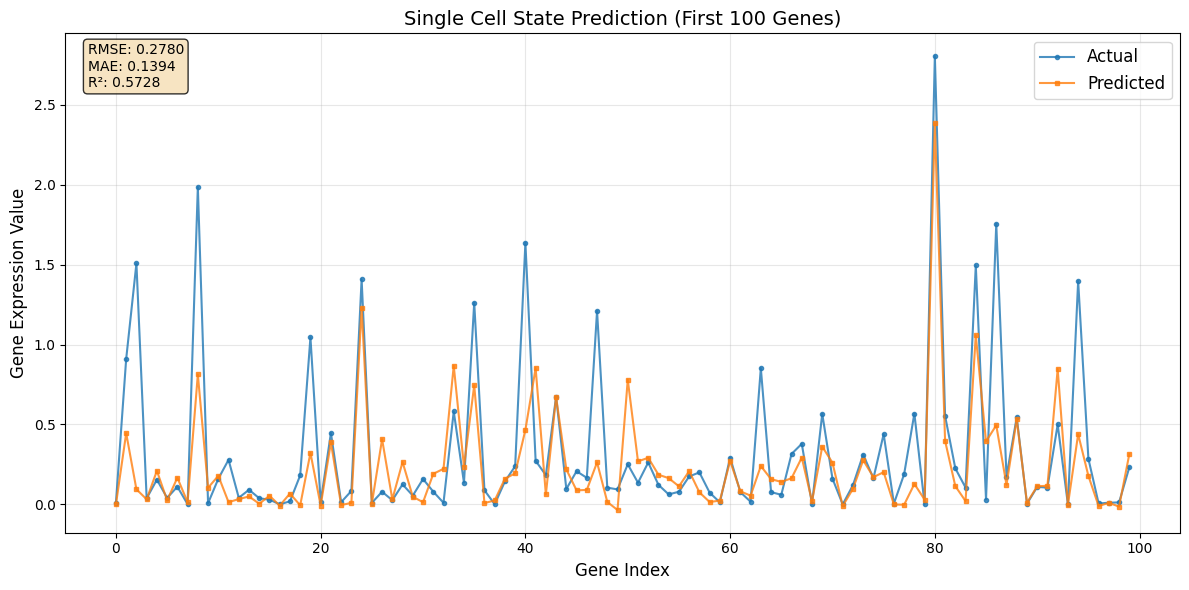

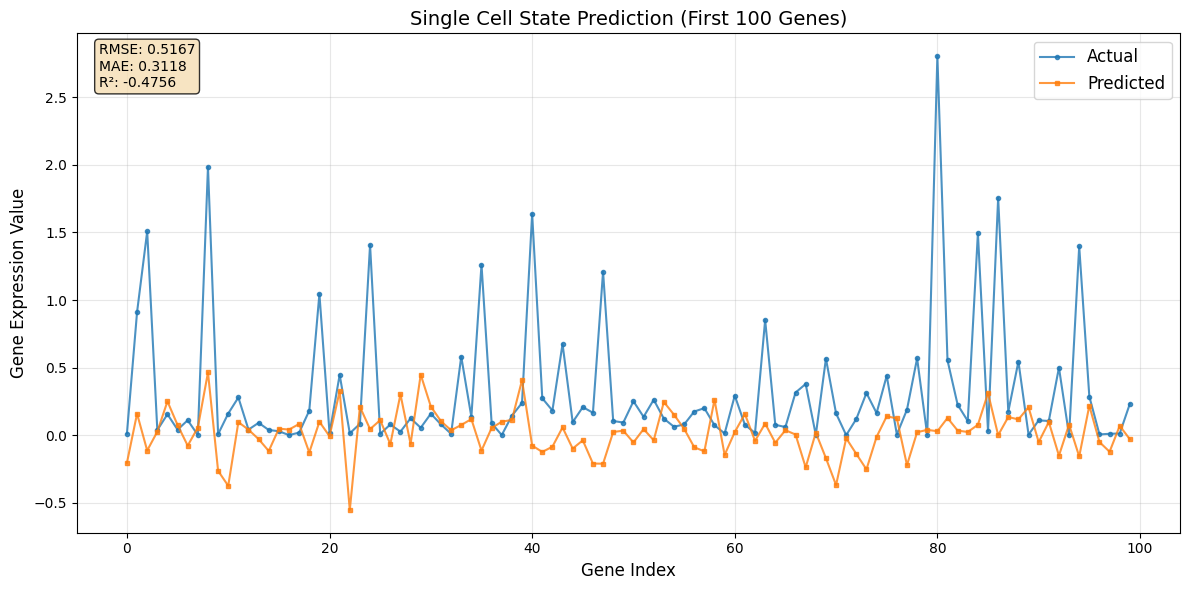

In [17]:
print("\nPlotting Training Histories")
plot_training_history(lstm_history, model_name="LSTM")
plot_training_history(ff_history, model_name="Feedforward")

print("\nPlotting Prediction Comparisons")
lstm_metrics = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R²': lstm_r2}
plot_prediction_comparison(y_test, y_pred_lstm, model_type='cell', metrics_dict=lstm_metrics)

ff_metrics = {'RMSE': ff_rmse, 'MAE': ff_mae, 'R²': ff_r2}
plot_prediction_comparison(y_test, y_pred_ff, model_type='cell', metrics_dict=ff_metrics)


Plotting Diagnostic Plots


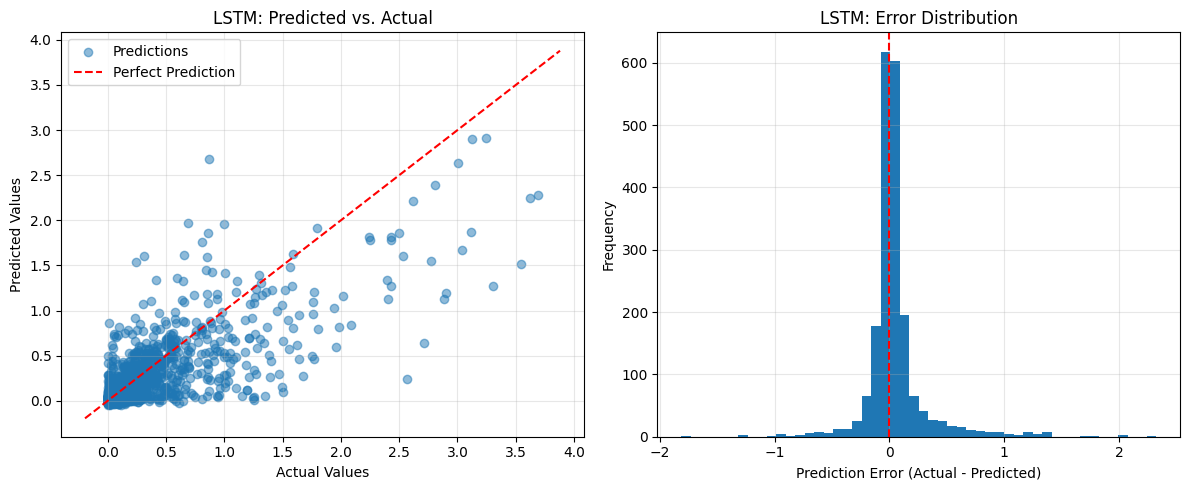

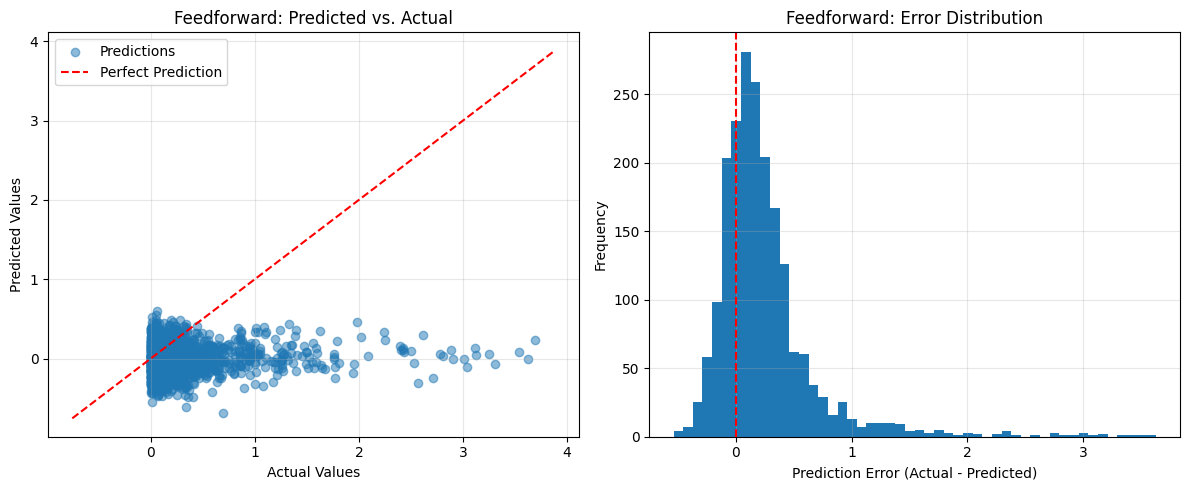

In [18]:
print("\nPlotting Diagnostic Plots")
plot_diagnostic_plots(y_test, y_pred_lstm, model_name="LSTM")
plot_diagnostic_plots(y_test, y_pred_ff, model_name="Feedforward")


Plotting Final Performance Comparison


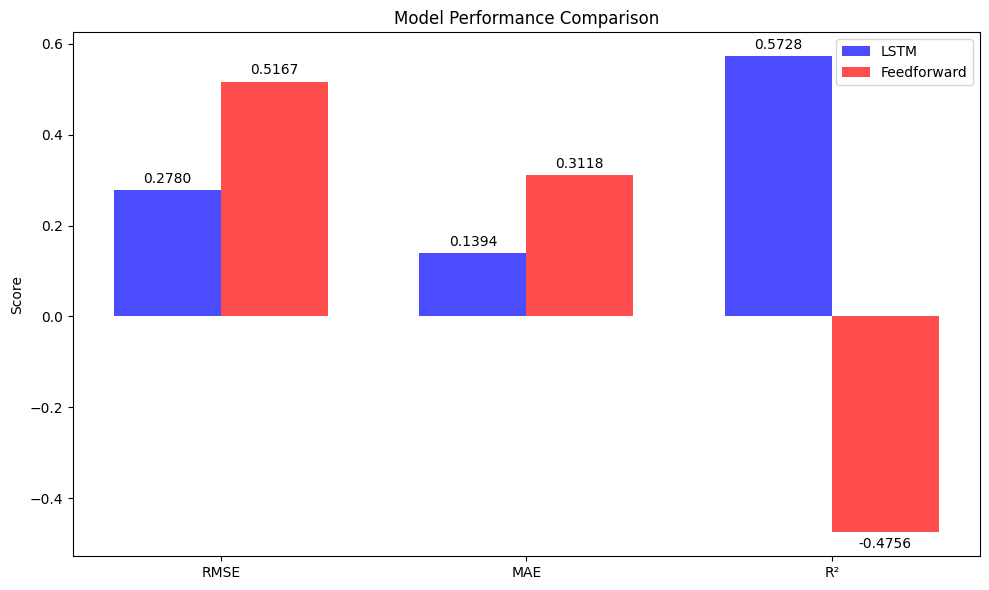

In [19]:
print("\nPlotting Final Performance Comparison")
lstm_metrics = {'RMSE': lstm_rmse, 'MAE': lstm_mae, 'R²': lstm_r2}
ff_metrics = {'RMSE': ff_rmse, 'MAE': ff_mae, 'R²': ff_r2}
plot_performance_comparison_bar_chart(lstm_metrics, ff_metrics)